Weather data from : https://www.ncdc.noaa.gov/cdo-web/review
Weather Station: CHICAGO MIDWAY AIRPORT, IL US (Station ID: GHCND:USW00014819)

- AWND - Average wind speed
- SNOW - Snowfall
- TMAX - Maximum temperature
- TAVG - Average Temperature.
- PRCP - Precipitation
- SNWD - Snow depth


This weather station only has precipitation and tmax

In [1]:
import pandas as pd

<Axes: xlabel='DATE'>

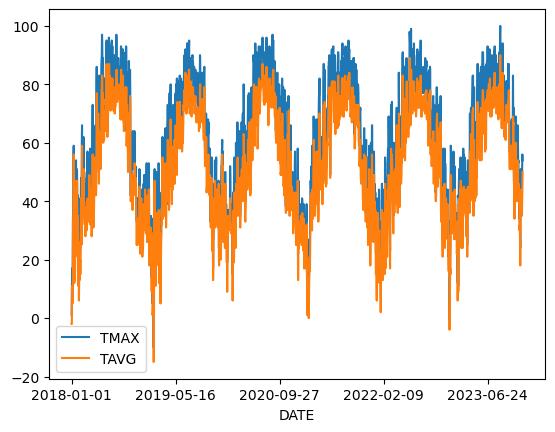

In [8]:
climate = pd.read_csv("Chigaco_data/CHI_weather_2018-2023.csv")
# plot tmax and tavg against date
climate.plot(x="DATE", y=["TMAX", "TAVG"])


In [57]:
import pandas as pd
import datetime as dt

trips_DO = pd.read_csv("Data/Chigaco_data/aggregated_data_PU_communityarea.csv")

trips_DO.head()

,pickup_community_area,trip_start_timestamp,trip_count,avg_trip_seconds,avg_trip_miles,avg_fare,avg_tips
0,14.0,2016-11-12 06:00:00+00:00,1,808.000000,8.500000,23.250000,0.000000
1,35.0,2016-11-06 07:45:00+00:00,2,610.500000,2.845000,10.750000,1.500000
2,39.0,2017-05-11 09:30:00+00:00,2,1050.000000,3.540000,25.750000,3.425000
3,35.0,2017-05-23 07:15:00+00:00,3,467.666667,1.546667,7.583333,1.233333
4,35.0,2016-01-29 09:15:00+00:00,5,993.600000,1.920000,13.100000,0.000000


In [58]:

# sort by date
trips_DO = trips_DO.sort_values(by=['trip_start_timestamp']).reset_index(drop=True)
# drop Nas
trips_DO = trips_DO.dropna()
# convert pickup_community_area to int
trips_DO['pickup_community_area'] = trips_DO['pickup_community_area'].astype(int)
# only keep date of the date time format column
trips_DO['trip_start_timestamp'] = trips_DO['trip_start_timestamp'].str.split(' ').str[0]

# merge trips and climate data on date
trips_DO = pd.merge(trips_DO, climate, how='left', left_on='trip_start_timestamp', right_on='DATE')

# conver tmax from fahrenheit into celsius
# trips_DO['TMAX'] = (trips_DO['TMAX'] - 32) * 5/9

trips_DO

# add a weekday index to the dataframe starting with Mondays = 0 tuesdays = 1 etc.
trips_DO['Weekday_index'] = pd.to_datetime(trips_DO['trip_start_timestamp']).dt.dayofweek

In [59]:
import holidays
# Initialize the holiday library for a specific country (e.g., United States)
us_holidays = holidays.US()

# Create a new column indicating whether each date is a holiday or not
trips_DO['holiday'] = trips_DO['trip_start_timestamp'].apply(lambda x: 1 if x in us_holidays else 0)

In [63]:
taxi_data = trips_DO

taxi_data.rename(columns={'trip_start_timestamp':'date_pickup' , 'pickup_community_area' : 'PULocationID' , 'trip_count' : 'trip_number' , 'TMAX' : 'tmax_obs'}, inplace=True)

In [65]:
import numpy as np
from matplotlib.cbook import boxplot_stats 

# add month and year factors
taxi_data['Year_fact'] = pd.factorize(pd.to_datetime(taxi_data['date_pickup']).dt.year)[0] + 1
taxi_data['Month_fact'] = pd.factorize(pd.to_datetime(taxi_data['date_pickup']).dt.month)[0] + 1
# log the dependent variable
taxi_data['log_total'] = np.log(taxi_data['trip_number'] + 1)
# remove NAs
taxi_data = taxi_data.dropna(subset=['tmax_obs'])

# add chebyshev_polynomials

taxi_data["cheby_0"] = 1
taxi_data["cheby_1"] = pd.to_datetime(taxi_data['date_pickup']).dt.dayofyear

# recursively defining other chebyshev polynomials for each day until 5th order
for i in range(2, 6):
    taxi_data[f"cheby_{i}"] = (2  * taxi_data["cheby_1"] * taxi_data[f"cheby_{i-1}"]) - taxi_data[f"cheby_{i-2}"]

# outlier filtering
out_weekdays = pd.DataFrame()
filtered_weekdays = pd.DataFrame()
counter = 1
for z in taxi_data['PULocationID'].unique():
    zcta_data = taxi_data[taxi_data['PULocationID'] == z]
    for w in taxi_data['Weekday_index'].unique():
        zcta_weekday = zcta_data[zcta_data['Weekday_index'] == w]
        out = np.ravel(boxplot_stats(zcta_weekday['log_total'])[0]['fliers'])
        out_ids = np.where(np.isin(zcta_weekday['log_total'], out))[0]
        out_df = zcta_weekday.iloc[out_ids]
        zcta_filtered = zcta_weekday = zcta_weekday.drop(out_df.index)
        if counter == 1:
            out_weekdays = out_df
            filtered_weekdays = zcta_filtered
        else:
            out_weekdays = pd.concat([out_weekdays, out_df])
            filtered_weekdays = pd.concat([filtered_weekdays, zcta_filtered])
        counter += 1


# add temperature bins
sequence_bins = np.arange(np.floor(taxi_data['tmax_obs'].min()), np.ceil(taxi_data['tmax_obs'].max()) + 1, 3)
temp_bins = pd.cut(taxi_data['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
taxi_data['temp_bins'] = temp_bins




# restrict taxi_data to temperature range -13 to 35
taxi_data_cut = taxi_data[(taxi_data['tmax_obs'] >= -13) & (taxi_data['tmax_obs'] <= 35)]



C:\Users\max-admin\AppData\Local\Temp\ipykernel_22736\1434305990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data['Year_fact'] = pd.factorize(pd.to_datetime(taxi_data['date_pickup']).dt.year)[0] + 1
C:\Users\max-admin\AppData\Local\Temp\ipykernel_22736\1434305990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data['Month_fact'] = pd.factorize(pd.to_datetime(taxi_data['date_pickup']).dt.month)[0] + 1
C:\Users\max-admin\AppData\Local\Temp\ipykernel_22736\1434305990.py:8: SettingWithCopy

In [4]:
import fastparquet as fp
import pandas as pd

# read parquet file as dataframe

df = fp.ParquetFile('High_Volume_FHV/2019/fhvhv_tripdata_2019-02.parquet').to_pandas()
